In [ ]:
# need rasterstats
! conda install -c conda-forge -y rasterstats

In [ ]:
# get data
! cp -r ~/data-store/data/iplant/home/shared/earthlab/forest_carbon_codefest/Disturbance/LF_Public_Events_1999_2022 ./LF_Events

In [2]:
! wget --no-check-certificate https://gaftp.epa.gov/EPADataCommons/ORD/Ecoregions/us/us_eco_l3.zip

--2024-03-12 23:18:52--  https://gaftp.epa.gov/EPADataCommons/ORD/Ecoregions/us/us_eco_l3.zip
Resolving gaftp.epa.gov (gaftp.epa.gov)... 134.67.100.99, 2620:117:506f:c7::f063
Connecting to gaftp.epa.gov (gaftp.epa.gov)|134.67.100.99|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 28424315 (27M) [application/zip]
Saving to: ‘us_eco_l3.zip’

us_eco_l3.zip       100%[===================>]  27.11M  2.92MB/s    in 8.4s    

2024-03-12 23:19:01 (3.21 MB/s) - ‘us_eco_l3.zip’ saved [28424315/28424315]



In [94]:
# get the NLCD rasters local
! ls /data-store/iplant/home/shared/earthlab/forest_carbon_codefest/Team_outputs/Team5/output_data/NLCD_sc/ | \
    grep -v "tif" | \
    parallel -j1 "cp /data-store/iplant/home/shared/earthlab/forest_carbon_codefest/Team_outputs/Team5/output_data/NLCD_sc/{}/*.tif ./"

In [97]:
# get the elevation data local
! cp /data-store/iplant/home/shared/earthlab/forest_carbon_codefest/Team_outputs/Team5/output_data/soro_elev.tif ./

In [107]:
from typing import Dict, Any, List
import multiprocessing

import fiona
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from rasterstats import zonal_stats

from collections import Counter
import shapely
import json
import matplotlib.pyplot as plt


def chunks(data, n):
    """Yield successive n-sized chunks from a slice-able iterable."""
    for i in range(0, len(data), n):
        yield data[i : i + n]


def nlcd_category_stats(x: np.ndarray) -> Dict[str, float] :
    """get the NLCD category stats for an input array"""

    # nonforest
    nonforest = (
        ((x >= 11) & (x <= 31)) | (x == 51) | (x == 52) | ((x >= 79) & (x <= 95)) & (x != 255)
    ).sum()

    # deciduous
    deciduous = (
        (x == 41) & \
        (x != 255)
    ).sum()

    # evergreen
    evergreen = (
        (x == 42) & \
        (x != 255)
    ).sum()

    # mixed
    mixed = (
        (x == 44) & \
        (x != 255)
    ).sum()

    total = nonforest + deciduous + evergreen + mixed

    return {"nonforest": nonforest / total, "deciduous": deciduous / total, "evergreen": evergreen / total, "mixed": mixed / total}


def simple_cats(input_cat: str) -> str:
    """Map catagories to something simple"""
    match input_cat:
        case "Insects" | "Insects/Disease":
            return "insect"
        case 'Wildfire':
            return "fire"
        case _:
            return "other"


def get_nlcd_stats(vector: str, nlcd_year: int) -> List[Dict[str, float]]:
    """Get NLCD pixel counts for each geometry in a dataframe."""

    with fiona.open(vector) as src:
        features = list(src)

    def nlcd_zonal_stats_partial(feats, tif):
        """Wrapper for zonal stats, takes a list of features"""
        return zonal_stats(feats, f"{year:d}_nlcd.tif", all_touched=True, add_stats={'nlcd':nlcd_category_stats})

    # Create a process pool using all cores
    cores = multiprocessing.cpu_count()
    p = multiprocessing.Pool(cores)

    # parallel map
    stats_lists = p.map(nlcd_zonal_stats_partial, chunks(features, cores))

    # flatten to a single list
    stats = list(itertools.chain(*stats_lists))


def get_elev_stats(vector: str) -> List[Dict[str, float]]:
    """Get Elevation mean for geometry in a dataframe."""

    with fiona.open(vector) as src:
        features = list(src)

    def elev_zonal_stats_partial(feats):
        """Wrapper for zonal stats, takes a list of features"""
        return zonal_stats(feats, "soro_elevation", all_touched=True, stats="mean")

    # Create a process pool using all cores
    cores = multiprocessing.cpu_count()
    p = multiprocessing.Pool(cores)

    # parallel map
    stats_lists = p.map(elev_zonal_stats_partial, chunks(features, cores))

    # flatten to a single list
    stats = list(itertools.chain(*stats_lists))



In [4]:
us_eco = gpd.read_file("us_eco_l3.zip").to_crs("EPSG:4326")
s_rock_aoi = us_eco[us_eco.US_L3NAME == "Southern Rockies"].geometry.unary_union

In [5]:
event_df = gpd.read_file(
    "./LF_Events/LF_Public_Events_1999_2022.gdb",
    layer="CONUS_230_PublicModelReadyEvents"
).to_crs("EPSG:4326")

In [6]:
s_rock_events = event_df[event_df.intersects(s_rock_aoi)]

In [9]:
print(s_rock_events.shape)
print(Counter(s_rock_events.Event_Type))

(69506, 16)
Counter({'Insects': 28857, 'Insects/Disease': 6430, 'Prescribed Fire': 6364, 'Other Mechanical': 6307, 'Herbicide': 5940, 'Thinning': 4471, 'Wildfire': 2637, 'Clearcut': 1704, 'Harvest': 1524, 'Planting': 1155, 'Chemical': 1098, 'Disease': 872, 'Mastication': 773, 'Wildland Fire': 430, 'Weather': 402, 'Biological': 262, 'Seeding': 145, 'Development': 75, 'Wildland Fire Use': 42, 'Reforestation': 12, 'Insecticide': 6})


In [19]:
with open("southern_rockies_eco.geojson", "w") as fh:
    fh.write(shapely.to_geojson(s_rock_aoi))

In [ ]:
s_r_e_utm = s_rock_events.to_crs("EPSG:32613")

In [51]:
s_r_e_utm["simple_cat"] = s_r_e_utm.Event_Type.apply(simple_cats)

In [52]:
Counter(s_r_e_utm.simple_cat)

Counter({'insect': 35287, 'other': 31582, 'fire': 2637})

(array([3.71354509e+08, 1.67876578e+07, 1.08313793e+09, 4.81023650e+07,
        3.23717963e+07, 7.00590772e+07, 3.17606010e+07, 1.36057349e+07,
        3.66288688e+07, 9.16233315e+07, 8.12809857e+07, 2.48954015e+08,
        5.24504472e+08, 4.92395035e+07, 2.92851964e+08, 1.61095877e+08,
        1.23119319e+09, 1.55588264e+08, 2.72827872e+09, 1.97993927e+09]),
 array([1999.  , 2000.15, 2001.3 , 2002.45, 2003.6 , 2004.75, 2005.9 ,
        2007.05, 2008.2 , 2009.35, 2010.5 , 2011.65, 2012.8 , 2013.95,
        2015.1 , 2016.25, 2017.4 , 2018.55, 2019.7 , 2020.85, 2022.  ]),
 <BarContainer object of 20 artists>)

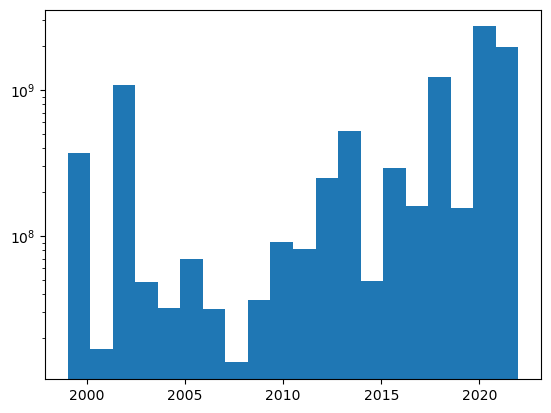

In [68]:
# type = "insect"
type = "fire"
# type = "other"
plt.hist(s_r_e_utm[s_r_e_utm.simple_cat == type].Year, bins=20, log=True, weights=s_r_e_utm[s_r_e_utm.simple_cat == type].area)
# s_r_e_utm.hist(by="simple_cat", column=["Year", "simple_cat"], bins=20, log=True)

(array([6.84419880e+05, 0.00000000e+00, 4.24415171e+05, 0.00000000e+00,
        0.00000000e+00, 2.82890738e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.98177811e+05, 3.29009793e+05,
        1.66991532e+05, 1.66991532e+05, 0.00000000e+00, 2.09032261e+09,
        1.43203251e+09, 1.76507457e+09, 2.20077988e+09, 3.00683024e+09]),
 array([2001.  , 2002.05, 2003.1 , 2004.15, 2005.2 , 2006.25, 2007.3 ,
        2008.35, 2009.4 , 2010.45, 2011.5 , 2012.55, 2013.6 , 2014.65,
        2015.7 , 2016.75, 2017.8 , 2018.85, 2019.9 , 2020.95, 2022.  ]),
 <BarContainer object of 20 artists>)

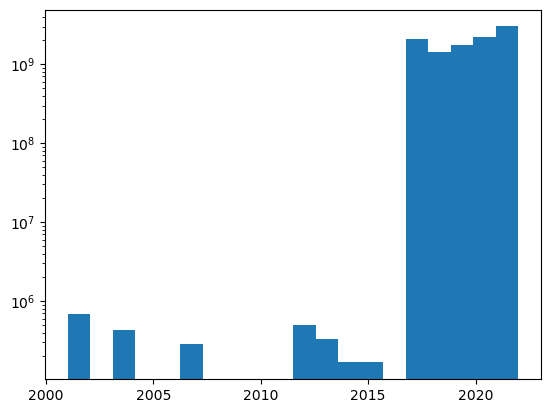

In [65]:
type = "insect"
plt.hist(s_r_e_utm[s_r_e_utm.simple_cat == type].Year, bins=20, log=True, weights=s_r_e_utm[s_r_e_utm.simple_cat == type].area)

In [ ]:
s_r_e_utm.to_file("southern_rockies_simplified_events.gpkg")

## Zonalstats

In [108]:
elevation_mean = get_elev_stats("southern_rockies_simplified_events.gpkg")

AttributeError: Can't pickle local object 'get_elev_stats.<locals>.elev_zonal_stats_partial'

1864022